In [61]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper


def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    print(fcd.shape)
    print(data.shape)
    print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


In [156]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
# Load coefficients to estimte Decay with LR
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
C = 0.2*C/np.max(C)
triu_idx = np.triu_indices(C.shape[1],1)
brunout = 5
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
params['seed'] = 2
sampling_freq = 10000
G_max = 25
DECAY_max = 60000
OBJ_RATE_max = 15
G_step = 0.5
DECAY_step = 20000
OBJ_RATE_step = 3
G_range = np.arange(0,G_max,G_step)
LR_range = np.logspace(0, 3,100)

#G_range = [1,2]
#LR_range = [10,200]
# Define the number of cores to use
NUM_CORES = 16
peak_autocorrelation_grid = np.zeros((len(G_range),len(LR_range)))
peak_time_grid = np.zeros((len(G_range),len(LR_range)))
power_grid = np.zeros((len(G_range),len(LR_range), params['N'],951)) # Hardcoded number of frequencies with the given parameters of filtering
std_slow_grid = np.zeros((len(G_range),len(LR_range)))
corr_to_sc_grid = np.zeros((len(G_range),len(LR_range)))
homeostatic_fittness_grid = np.zeros((len(G_range),len(LR_range)))
rates_grid = np.zeros((len(G_range),len(LR_range),params['N']))
fic_t_grid = np.zeros((len(G_range),len(LR_range),params['N']))


In [157]:
from scipy.signal import find_peaks
def get_peak_and_ms(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    peaks, _ = find_peaks(autocorr, height=(0.2,0.8), prominence=0.2)
    if peaks.size==0:
        autocorr_value = 0
        time = 0
    else:
        autocorr_value = autocorr[peaks[0]]
        time = peaks[0]
    return autocorr_value,time


def grid_step(args):
    G_tuple, LR_tuple = args
    idx_LR,LR = LR_tuple[0],LR_tuple[1]
    idx_G,G = G_tuple[0],G_tuple[1]
    DECAY = np.exp(a+np.log(LR)*b)
    OBJ_RATE = 3.44
    print(f"Running - G:{G} / DECAY:{DECAY} / OBJ_RATE:{OBJ_RATE} / LR:{LR} \n")
    with_decay = DECAY>0
    params['lrj'] = LR
    params['G'] = G
    # Using heuristic linear rule 
    params['taoj'] = DECAY if with_decay else 10 # If 0 it means no plasticity at all. We put some value so it does not crash
    params['obj_rate'] = OBJ_RATE
    #params['taoj'] = 210000
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    rates, rates_inh, _, fic_t = dmf.run(params, nb_steps,
                                            return_rate=True, return_bold=False, return_fic=True, 
                                            with_decay=with_decay, with_plasticity=True)        
    rates = rates[:, np.ceil(brunout * 1000).astype(int):]
    rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
    fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
    rates_fc = np.corrcoef(rates)
    power_spectrum,frequencies = psd_array_multitaper(rates, verbose=False,sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
    peak_autocorrelation,peak_time = get_peak_and_ms(rates)
    corr_to_sc = pearsonr(rates_fc[triu_idx[0],triu_idx[1]], C[triu_idx[0],triu_idx[1]])[0]
    
    homeostatic_fittness =  OBJ_RATE - np.mean(rates)  
    return idx_G,idx_LR, peak_autocorrelation,peak_time,corr_to_sc ,homeostatic_fittness,np.mean(rates,axis=1),np.mean(fic_t,axis=1), power_spectrum


##  Grid seacrch


In [64]:
from multiprocessing import Pool,Manager


# Define the number of cores to use

# Create a list of argument tuples for the nested loop function
args_list = [((idx_G,G), (idx_LR,LR))
             for idx_G,G in enumerate(G_range)             
             for idx_LR,LR in enumerate(LR_range)]

manager = Manager()
results_list = manager.list()
# Create a pool of worker processes
with Pool(processes=NUM_CORES) as pool:
    # Map the nested loop function to the argument list across multiple processes
    results_list.extend(pool.map(grid_step, args_list))



Running - G:0.0 / DECAY:1579.8468395964962 / OBJ_RATE:3.44 / LR:247.70763559917114 
Running - G:0.0 / DECAY:495437.4241216812 / OBJ_RATE:3.44 / LR:1.0 
Running - G:0.5 / DECAY:7281.284950784336 / OBJ_RATE:3.44 / LR:57.22367659350217 
Running - G:1.0 / DECAY:33558.38629778779 / OBJ_RATE:3.44 / LR:13.219411484660293 
Running - G:1.5 / DECAY:154665.73530956803 / OBJ_RATE:3.44 / LR:3.0538555088334154 




Running - G:1.5 / DECAY:493.1968422770515 / OBJ_RATE:3.44 / LR:756.463327554629 
Running - G:2.0 / DECAY:2273.072715304125 / OBJ_RATE:3.44 / LR:174.7528400007685 

Running - G:2.5 / DECAY:10476.262469980702 / OBJ_RATE:3.44 / LR:40.370172585965555 
Running - G:3.0 / DECAY:48283.574300544155 / OBJ_RATE:3.44 / LR:9.326033468832199 

Running - G:3.5 / DECAY:222531.9911482185 / OBJ_RATE:3.44 / LR:2.154434690031884 

Running - G:3.5 / DECAY:709.6082084390194 / OBJ_RATE:3.44 / LR:533.6699231206312 

Running - G:4.0 / DECAY:3270.4813147454993 / OBJ_RATE:3.44 / LR:123.28467394420659 




Running -

In [65]:
for results in results_list:
    idx_G = results[0]    
    idx_LR = results[1]
    peak_autocorrelation = results[2]
    peak_time = results[3]    
    corr_to_sc = results[4]
    homeostatic_fittness = results[5]
    rates = results[6]
    fic_t = results[7]
    power_spectrum = results[8]
    peak_autocorrelation_grid[idx_G,idx_LR] = peak_autocorrelation
    peak_time_grid[idx_G,idx_LR] = peak_time    
    power_grid[idx_G, idx_LR] = power_spectrum
    corr_to_sc_grid[idx_G,idx_LR] = corr_to_sc
    homeostatic_fittness_grid[idx_G,idx_LR] = homeostatic_fittness
    rates_grid[idx_G,idx_LR,:] = rates
    fic_t_grid[idx_G,idx_LR,:] = fic_t

In [66]:
import os

# Assuming these arrays are already populated with data

arrays_to_save = {
    'peak_autocorrelation_grid': peak_autocorrelation_grid,
    'peak_time_grid': peak_time_grid,
    'power_grid': power_grid,
    'corr_to_sc_grid': corr_to_sc_grid,
    'homeostatic_fittness_grid': homeostatic_fittness_grid,
    'rates_grid': rates_grid,
    'fic_t_grid': fic_t_grid
}

results_folder = "./Results/G_LR"


In [67]:
# Save
for array_name, array_data in arrays_to_save.items():
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    np.save(file_name, array_data)


In [191]:
# Load
peak_autocorrelation_grid = np.load("./Results/G_LR/peak_autocorrelation_grid.npy")
peak_time_grid = np.load("./Results/G_LR/peak_time_grid.npy")
power_grid = np.load("./Results/G_LR/power_grid.npy")


In [101]:
peak_time_grid.max().max()

62483.0

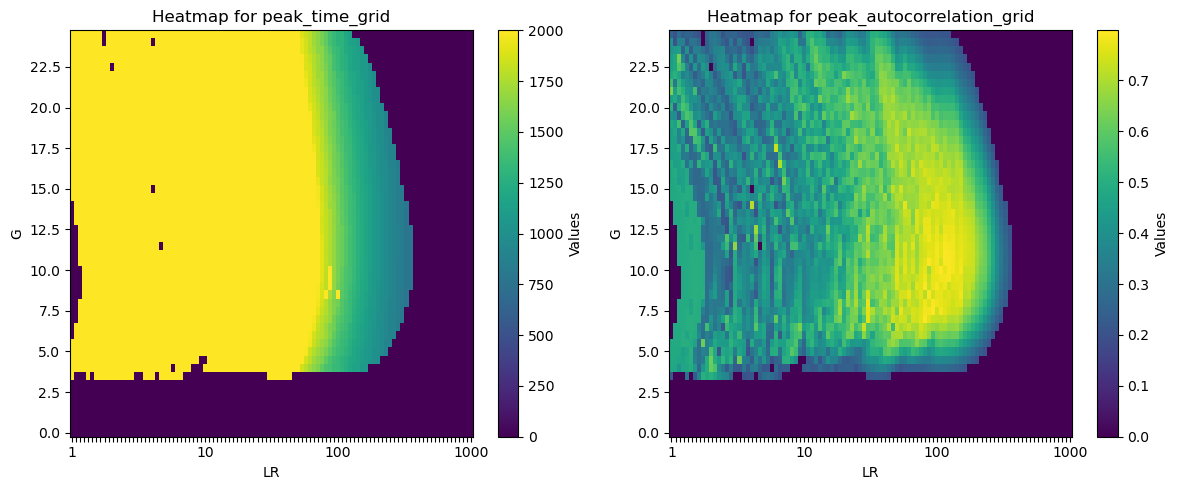

In [115]:
# Create subplots
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Heatmap for peak_time_grid
im1 = axes[0].imshow(peak_time_grid, cmap='viridis', origin='lower', aspect='auto', vmax=2000)
axes[0].set_title('Heatmap for peak_time_grid')
axes[0].set_xlabel('LR')
axes[0].set_ylabel('G')
# Set logarithmic tick labels for LR
log_labels = ['' for _ in range(len(LR_range))]
log_labels[0] = 1
log_labels[33] = 10
log_labels[66] = 100
log_labels[99] = 1000
axes[0].set_xticks(range(len(LR_range)))
axes[0].set_xticklabels(log_labels)
axes[0].set_yticks(range(0,50,5))
axes[0].set_yticklabels(G_range[range(0,50,5)])
plt.colorbar(im1, ax=axes[0], label='Values')
# Heatmap for peak_autocorrelation_grid
im2 = axes[1].imshow(peak_autocorrelation_grid, cmap='viridis', origin='lower', aspect='auto')
axes[1].set_title('Heatmap for peak_autocorrelation_grid')
axes[1].set_xlabel('LR')
axes[1].set_ylabel('G')
axes[1].set_xticks(range(len(LR_range)))
axes[1].set_xticklabels(log_labels)
axes[1].set_yticks(range(0,50,5))
axes[1].set_yticklabels(G_range[range(0,50,5)])
plt.colorbar(im2, ax=axes[1], label='Values')
plt.tight_layout()
plt.show()

In [205]:
peak_autocorrelation_grid[12,70]

0.6182853730169675

In [169]:
LR_range[70]

132.19411484660287

In [197]:
G_range[12]

6.0

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

idx_OBJ_RATE = 1

for i, DECAY_value in enumerate(DECAY_range):
    for j, OBJ_RATE_value in enumerate(OBJ_RATE_range):
        fig, axs = plt.subplots(3, 2, figsize=(15, 10))
        plt.axis('off')
        ax = axs[0,0 ]  # Get the correct axis
        slice_data = homeostatic_fittness_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='coolwarm', aspect='auto', vmin=-OBJ_RATE_value/2, vmax=OBJ_RATE_value/2)
                            #norm=SymLogNorm(linthresh=3, linscale=1,vmin=-np.max(slice_data), vmax=np.max(slice_data)))
        plt.colorbar(heatmap, ax=ax),#ticks=np.linspace(np.min(slice_data), np.max(slice_data), 6))            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'Homeostatic fittness')

        ax = axs[0,1]  # Get the correct axis
        slice_data = corr_to_sc_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='hot', aspect='auto', vmin=np.min(slice_data), vmax=np.max(slice_data))
        plt.colorbar(heatmap, ax=ax)            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'corr_to_sc')

        ax = axs[1,0]  # Get the correct axis
        slice_data = mean_slow_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='plasma', aspect='auto', vmin=np.min(slice_data), vmax=np.max(slice_data))
        plt.colorbar(heatmap, ax=ax)            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'mean_plow/ptot')

        ax = axs[1,1]  # Get the correct axis
        slice_data = std_slow_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='plasma', aspect='auto', vmin=np.min(slice_data), vmax=np.max(slice_data))
        plt.colorbar(heatmap, ax=ax)            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'std_plow/ptot')

        ax = axs[2,0]  # Get the correct axis
        slice_data = amount_slow_regions_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='viridis', aspect='auto', vmin=np.min(slice_data), vmax=np.max(slice_data))
        plt.colorbar(heatmap, ax=ax)            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'amount_slow_regions')

        ax = axs[2,1]
        min_idx = np.unravel_index(np.argmin(np.abs(homeostatic_fittness_grid[:, i, j, :])), homeostatic_fittness_grid[:, i, j, :].shape)
        ax.bar(np.arange(params['N']), rates_grid[min_idx[0],i,j,min_idx[1],:], edgecolor='none')
        ax.plot([0, params['N'] + 1], [OBJ_RATE_value, OBJ_RATE_value], 'r--')
        ax.set_ylabel('E Firing Rate (Hz)')
        ax.set_xlabel('Regions')
        ax.set_title(f'Hom Fit: {np.min(np.abs(homeostatic_fittness_grid[:, i, j, :])):.2f}\nG={G_range[min_idx[0]]} LR={LR_range[min_idx[1]]}')
        

        plt.tight_layout()
        plt.savefig(f'./plots/DECAY_{DECAY_value}_OBJ_RATE_{OBJ_RATE_value}.png')  # Save the plot
        plt.close()


### One Run Sanity Check

In [57]:
a

13.11319633642533

In [225]:
nb_steps = 100000
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]

a = 13.303
b = -0.9149

C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
params['seed'] = 1
params['G'] = 5#G_range[idx_G]
params['lrj'] = LR_range[70] #LR_range[idx_LR]
params['obj_rate'] = 1.22#OBJ_RATE_range[idx_OBJ_RATE]
params['taoj'] = np.exp(a+np.log(params['lrj'])*b)
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
N = C.shape[0]

with_decay = True
with_plasticity = True
rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True, with_plasticity=with_plasticity, with_decay=with_decay)

brunout = 5
# Slicing and computations
bold = np.random.rand(N, 150)# bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
rates = rates[:, np.ceil(brunout * 1000).astype(int):]
rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
rates_fc = np.corrcoef(rates)
rates_inh_fc = np.corrcoef(rates_inh)
T = len(bold.T)
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b,a = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')
filt_bold = lfilter(b,a,bold)
time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
# Replace 'compute_fcd' with the appropriate function or code that computes time_fc
bold_fc = np.corrcoef(filt_bold)
fcd = np.corrcoef(time_fc)
mean_fic_dist = np.zeros(N)
for n in range(N):
    data = fic_t[:, n]
    mean_fic_dist[n] = np.mean(data)


# Assuming 'rates' is your firing rates variable
sampling_freq = 10000  # Replace with your actual sampling frequency (e.g., 1000 Hz)
# Calculate the power spectral density using multitaper method
power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
four_idx_freq = np.where(frequencies >= 4)[0][0]+1    
one_idx_freq = np.where(frequencies >= 1)[0][0]
plow_ptot = np.sum(power_spectrum[:, one_idx_freq:four_idx_freq], axis=1)/np.sum(power_spectrum[:,:], axis=1)    

(4005, 119)
(150, 90)
(31, 90)
    Using multitaper spectrum estimation with 30 DPSS windows


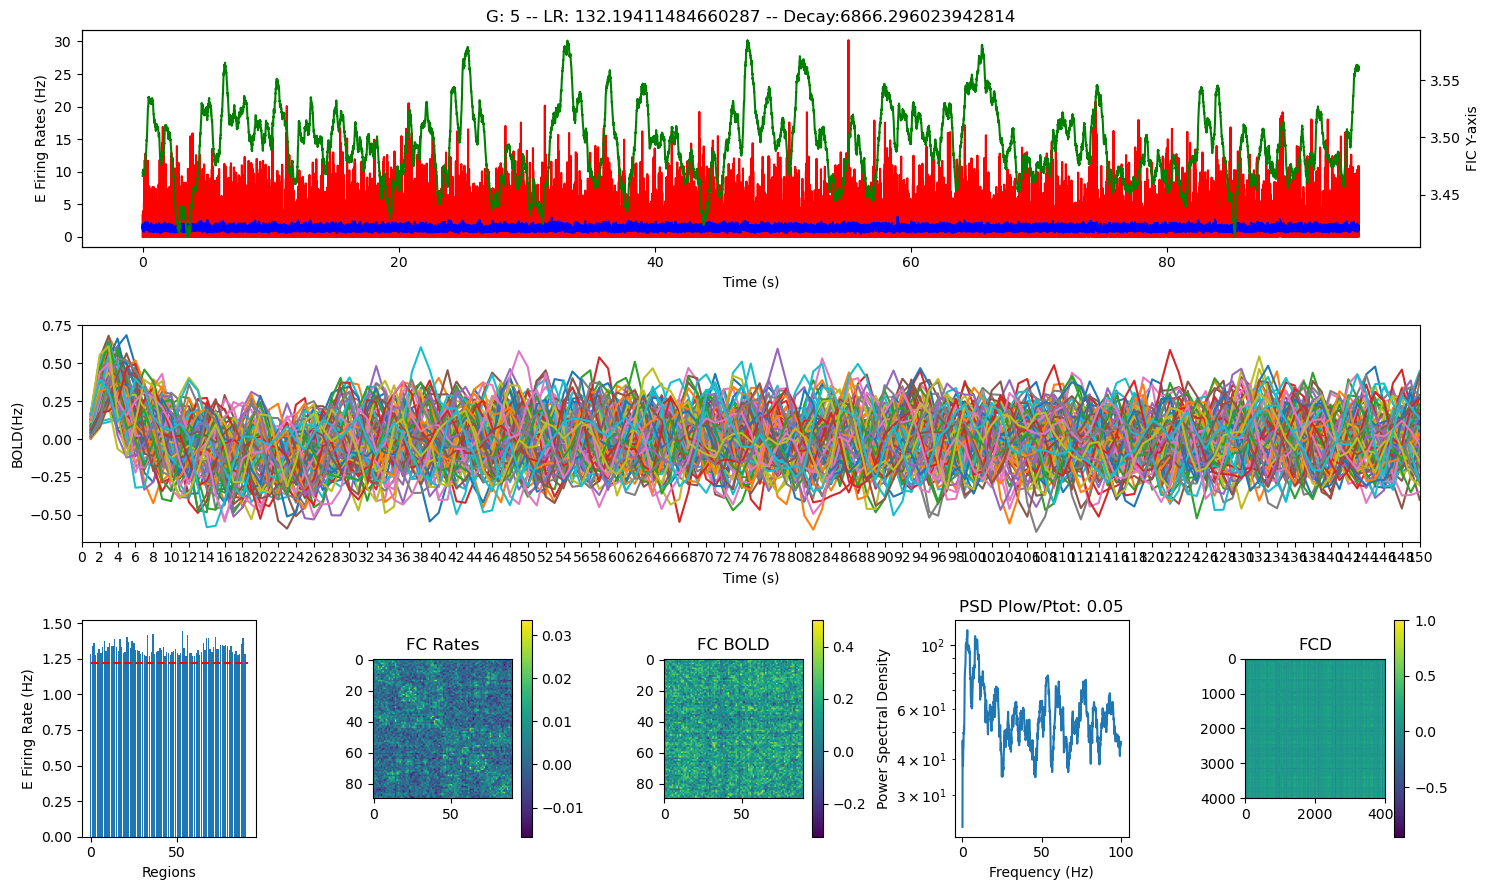

In [226]:
fig = plt.figure(figsize=(15, 9))
plt.axis('off')
#plt.title(f"G: {G_range[obs_idx_G]} -- LR: {LR_range[obs_idx_LR]}")
plt.title(f"G: {params['G']} -- LR: {params['lrj'] if with_plasticity else 'No plasticity '} -- Decay:{params['taoj'] if with_decay else 'No decay'}")

#sel_t = np.arange(9000, 19000) #np.arange(1,rates.shape[1] +1 ) 

sel_t = np.arange(1,rates.shape[1] +1 ) 
sel_t_bold = np.arange(1, bold.shape[1] + 1)

four_idx_freq = np.where(frequencies >= 4)[0][0]+1    
one_idx_freq = np.where(frequencies >= 1)[0][0]
plow_ptot = np.sum(power_spectrum[:, one_idx_freq:four_idx_freq], axis=1)/np.sum(power_spectrum[:,:], axis=1)                                        
slowest_reg = np.argmax(plow_ptot)


plt.subplot(3, 1, 1)
plt.plot(sel_t / 1000, rates[slowest_reg,sel_t-1], 'r')
plt.plot(sel_t / 1000, np.mean(rates[:,sel_t-1], axis=0), 'b')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t / 1000, np.mean(fic_t[:,sel_t-1], axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


"""
plt.subplot(3, 1, 1)
plt.plot(sel_t / 10000, rates[slowest_reg,sel_t-1], 'r')
plt.plot(sel_t / 10000, np.mean(rates[:,sel_t-1], axis=0), 'b')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t / 10000, np.mean(fic_t[:,sel_t-1], axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')
"""

plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)

plt.semilogy(frequencies, power_spectrum[slowest_reg,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[slowest_reg, one_idx_freq:four_idx_freq])/np.sum(power_spectrum[slowest_reg,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()


In [214]:
all_times = np.zeros(rates.shape[0])
all_peaks = np.zeros(rates.shape[0])
all_autocorr = np.zeros_like(rates)
for idx in range(rates.shape[0]):
    signal_reg = rates[idx]
    signal_reg -= np.mean(signal_reg)

    # Calculate autocorr_regelation function
    autocorr_reg = np.correlate(signal_reg, signal_reg, mode='full')
    
    # Normalize the autocorr_regelation function
    autocorr_reg = autocorr_reg / np.var(signal_reg) / len(signal_reg)
    autocorr_reg = autocorr_reg[len(signal_reg)-1:]
    all_autocorr[idx] = autocorr_reg
    peaks, _ = find_peaks(autocorr_reg, height=(0.2,0.8), prominence=0.2)
    if peaks.size==0:
        autocorr_reg_value = 0
        time = 0
    else:
        autocorr_reg_value = autocorr_reg[peaks[0]]
        time = peaks[0]
    all_peaks[idx] = autocorr_reg_value
    all_times[idx] = time

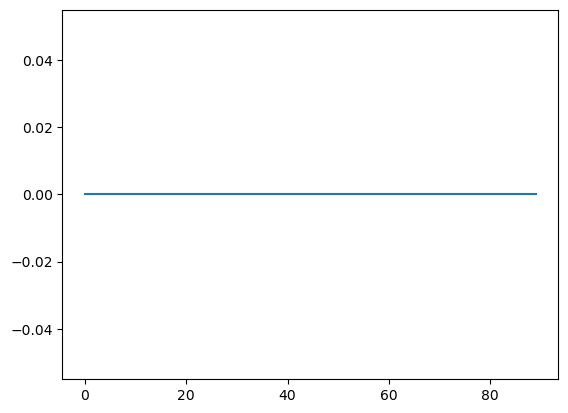

In [215]:
plt.plot(all_peaks)

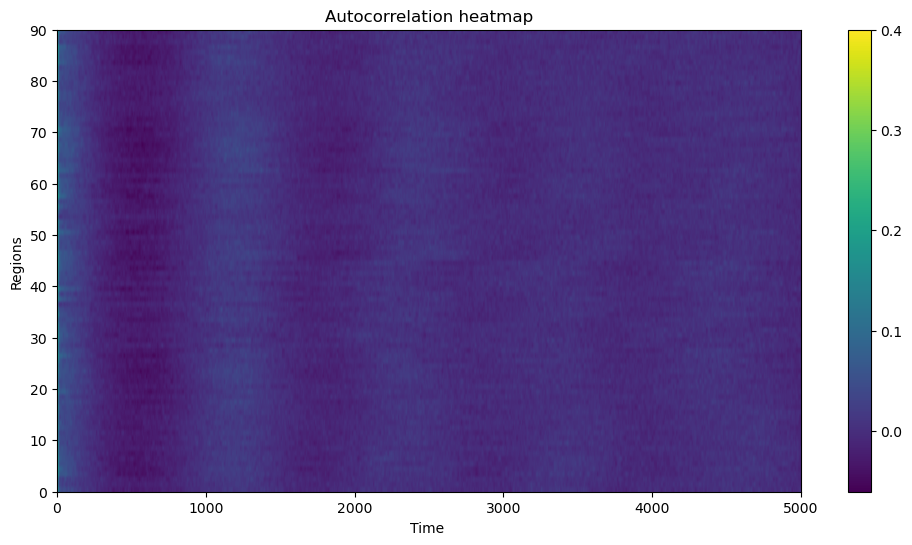

In [224]:
all_autocorr

import matplotlib.pyplot as plt
import numpy as np

# Assuming your matrix is named 'heatmap_data'
heatmap_data = all_autocorr[:,:5000] # Replace this with your actual data

# Set the size of the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the heatmap
im = ax.imshow(heatmap_data, cmap='viridis', aspect='auto', extent=[0, 5000, 0, 90], vmax=0.4)
plt.colorbar(im, ax=ax)

# Add labels and title if needed
ax.set_xlabel('Time ')
ax.set_ylabel('Regions')
ax.set_title('Autocorrelation heatmap')

# Show the plot
plt.show()


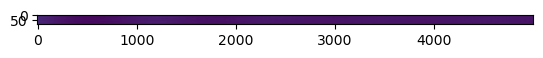

In [221]:
plt.imshow(all_autocorr[:,:5000])

In [217]:
signal = np.mean(rates, axis=0)
signal -= np.mean(signal)

# Calculate autocorrelation function
autocorr = np.correlate(signal, signal, mode='full')

# Normalize the autocorrelation function
autocorr = autocorr / np.var(signal) / len(signal)
autocorr = autocorr[len(signal)-1:]
peaks, _ = find_peaks(autocorr, height=(0.2,0.8), prominence=0.2)
if peaks.size==0:
    autocorr_value = 0
    time = 0
else:
    autocorr_value = autocorr[peaks[0]]
    time = peaks[0]

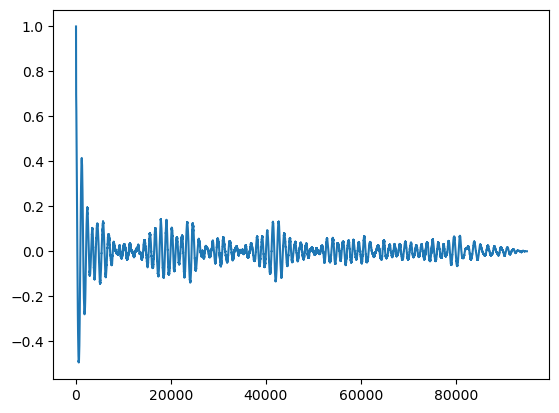

In [218]:
plt.plot(autocorr)

In [165]:
autocorr_value

0.24124062358418175